In [10]:
#Importando Pacotes:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import geopandas as gpd
import altair as alt
import os as os
#Configurando Altair:
alt.renderers.enable('notebook')
#Importando Módulos:
from data import data
from data2 import data2
from analyze import analyze
#Importando Mais Limpeza de dados:
import clean_data as cd

C:\Users\Bianca\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


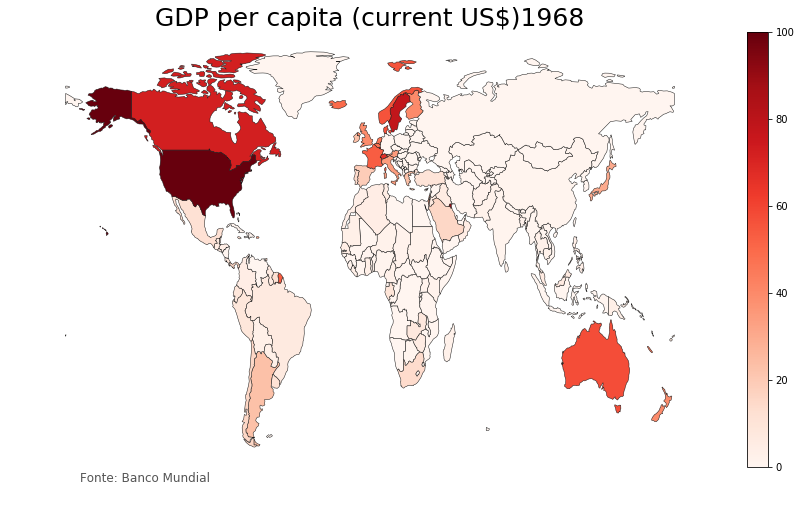

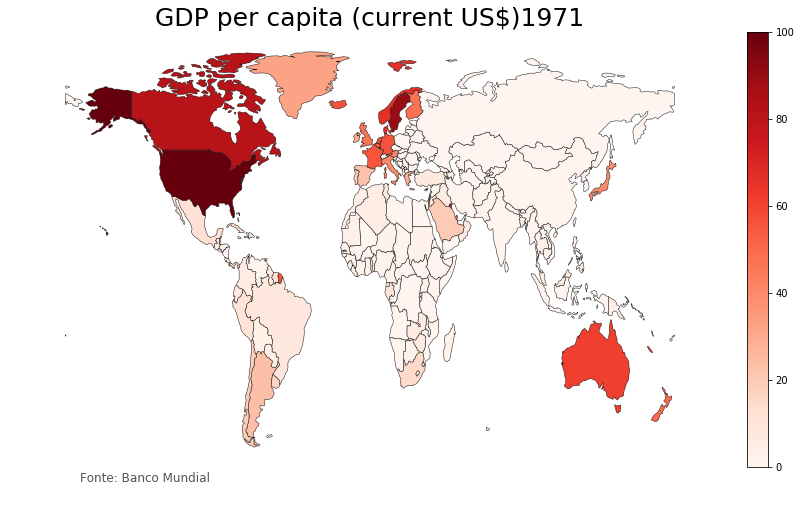

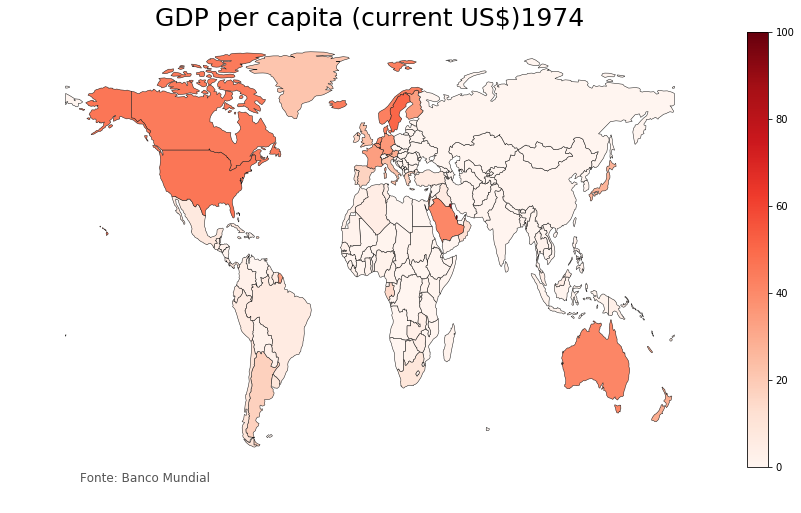

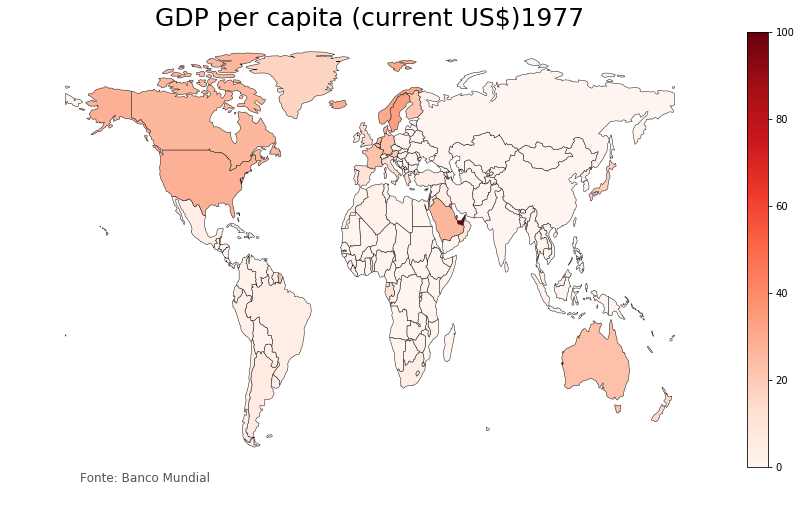

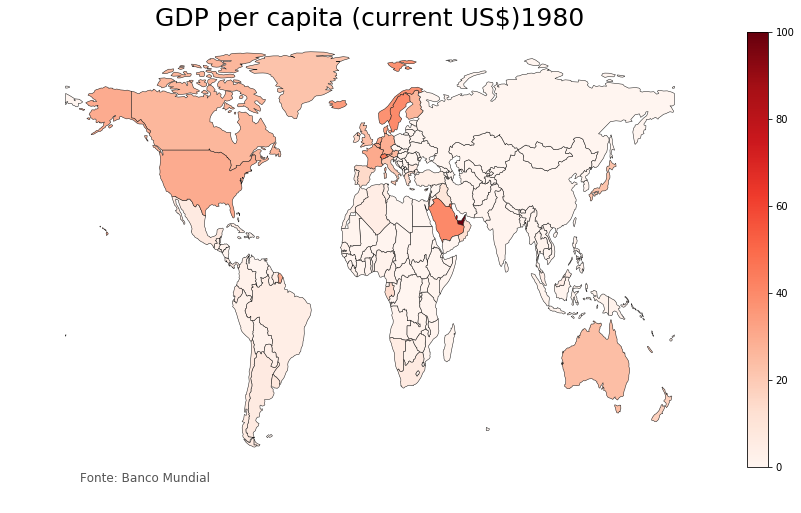

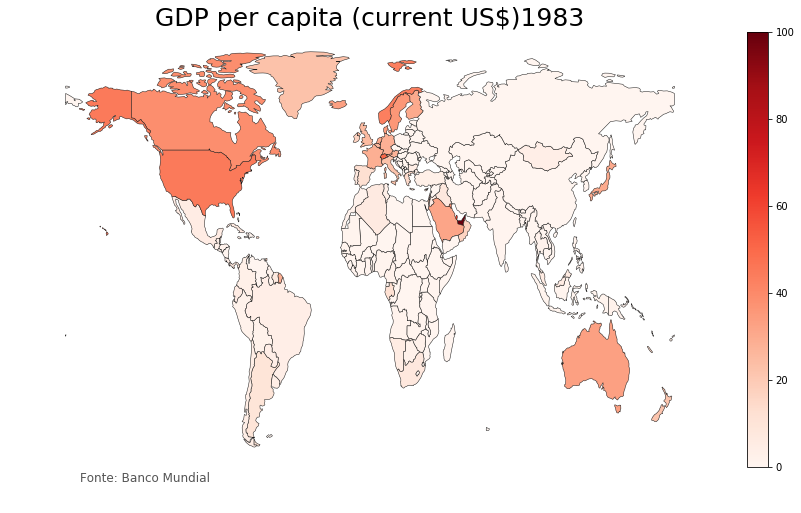

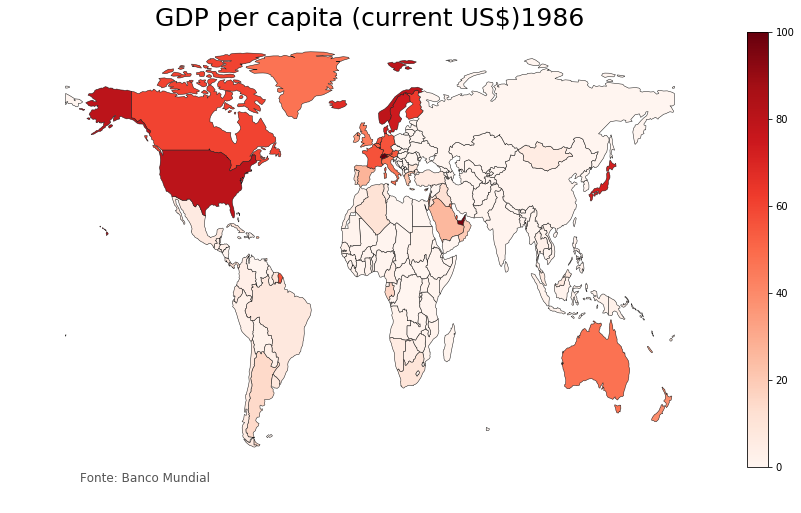

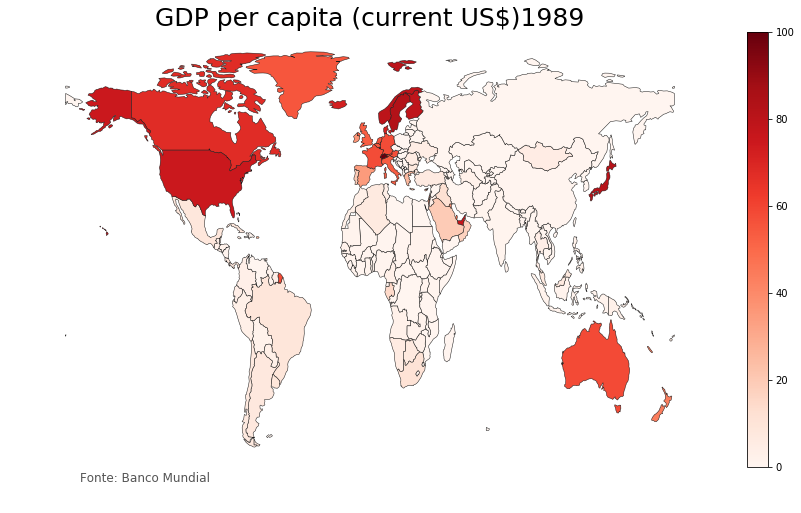

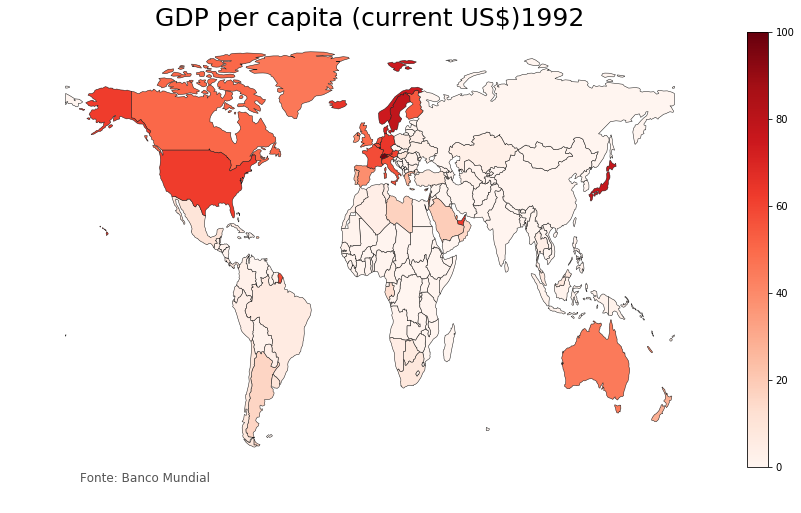

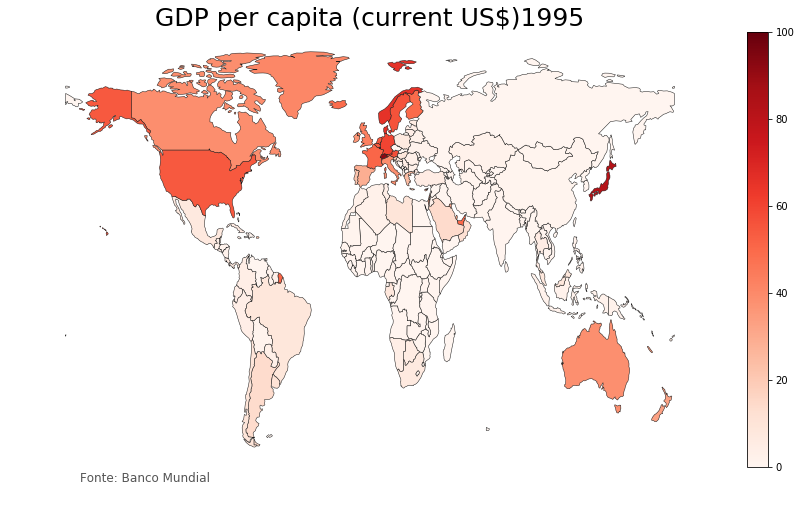

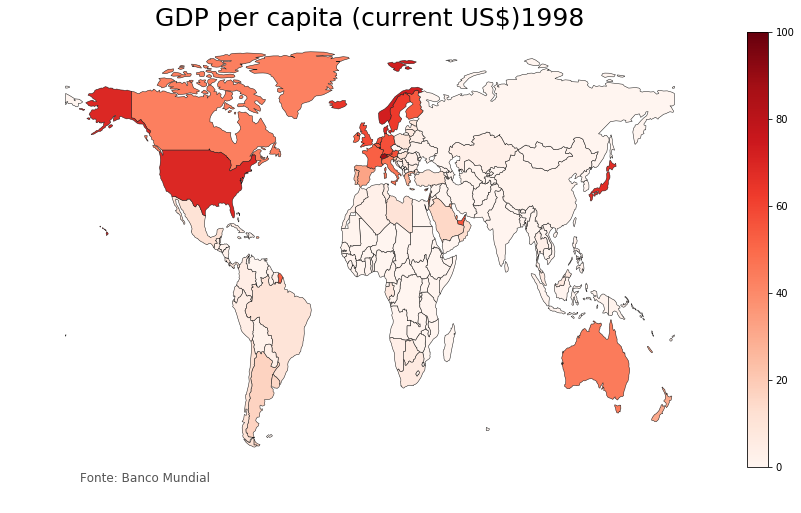

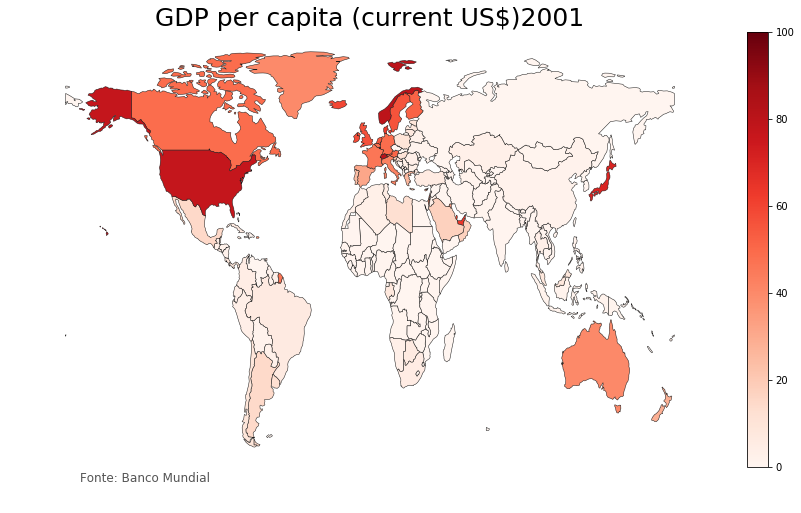

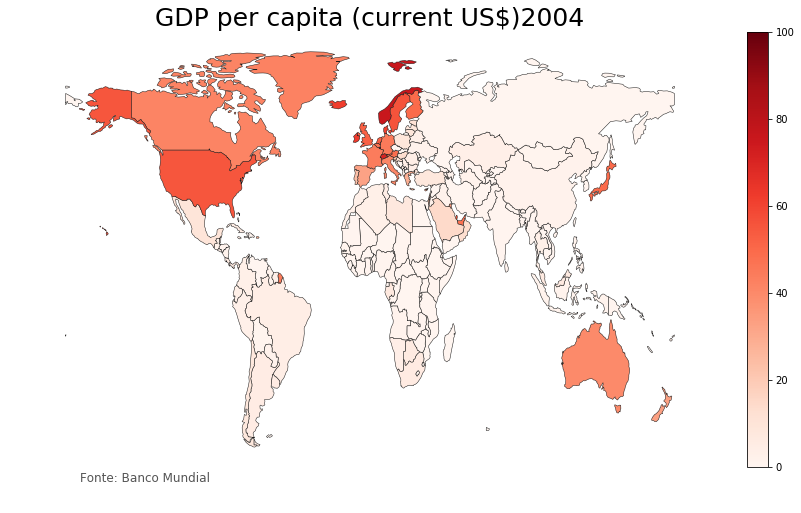

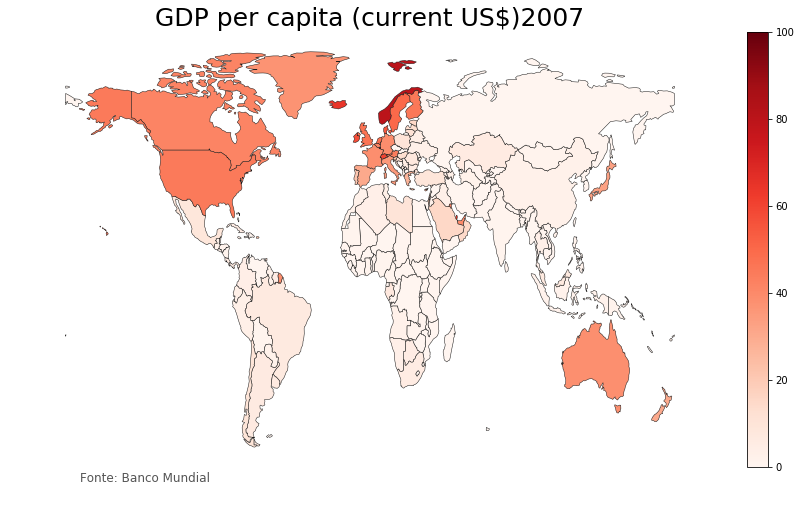

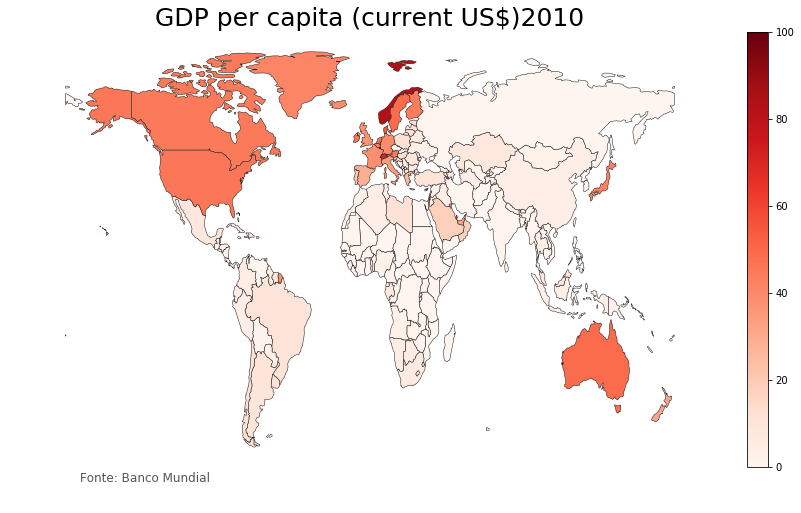

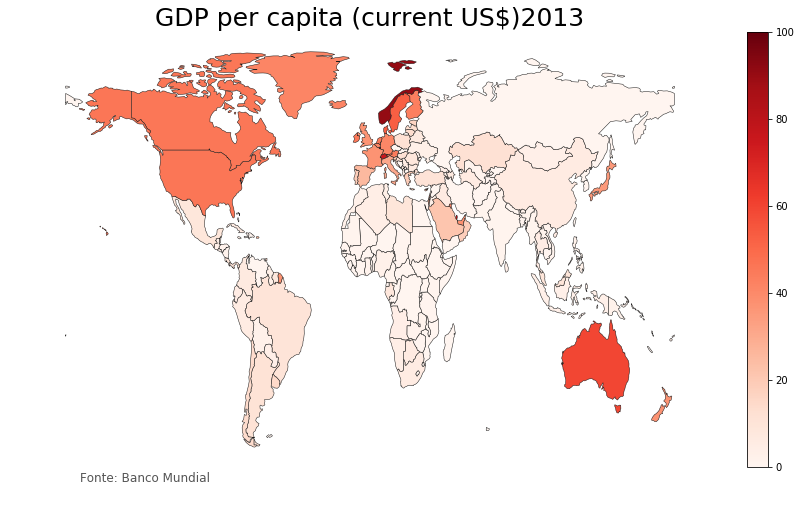

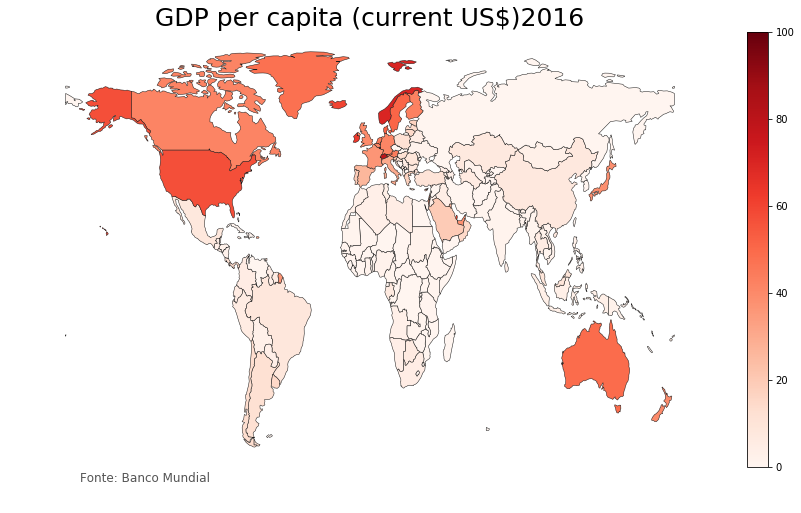

In [11]:
list_year= [str(num) for num in range(1968,2017,3)]
for year in  list_year:
    #Dados do PIB per capita de 'year':
    gdp = analyze(data,"GDP per capita (current US$)")
    gdp2017 = pd.DataFrame(gdp[year])
    #Mapa do Mundo:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    #Eliminando a Antarctica:
    world = world[(world.pop_est>0) & (world.name!="Antarctica")]
    #Mesclando as tabelas:
    merged = world.set_index('name').join(gdp2017)
    #Definindo dimensões e variáveis para o gráfico e legenda:
    variable = year
    vmin,vmax = 0,100
    fig, ax = plt.subplots(1, figsize=(15, 8))
    #Plotando o gráfico:
    imagem=merged.plot(column=variable, cmap='Reds',linewidth=0.5, ax=ax, edgecolor='0.1') 
    #Colocando legenda:
    ax.axis('off')
    ax.set_title("GDP per capita (current US$)" + year, fontdict={'fontsize': '25', 'fontweight' : '3'})
    ax.annotate('Fonte: Banco Mundial',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    #Salvando cada imagem do diretório
    caminho = os.path.join('Pastadogif', year+'_gdp.png')
    grafico = imagem.get_figure()
    grafico.savefig(caminho, dpi=300)

In [4]:
#2. ANALISE DO MERCADO DE CAPITAIS:

#2.1 Criando DataFrame resumido tomando apenas anos com grande quantidade de dados 
market = analyze(data,"Market capitalization of listed domestic companies (current US$)")[[str(num) for num in range(1987,2018)]]
#Criando variáveis para guardar resultados das concatenações no for e que transforme inteiros em strings para que possamos acessá-las:
list_year= [str(num) for num in range(1987,2018)]
top_market=pd.DataFrame()
#Interação para obter apenas os quatro países com maior mercado de capitais em cada ano, mantendo a informação desse pais em todos os anos
for i in list_year:
    market = pd.DataFrame(market[i])
    market = market[market[i]>0].sort_values(i)[-4:]
    top_market = pd.concat([top_market, market], axis=1, sort=False)
    market = analyze(data,"Market capitalization of listed domestic companies (current US$)")[[str(num) for num in range(1987,2018)]]
#Eliminando variáveis Nan.
top_market=top_market.fillna(0)
top_market=market.T[top_market.index].T
top_market

,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Country Name,,,,,,,,,,,,,,,,,,,,,
Canada,4.056009e+11,4.468064e+11,5.433966e+11,4.586786e+11,5.086332e+11,4.579499e+11,5.955164e+11,5.757164e+11,6.717428e+11,8.797976e+11,...,1.033652e+12,1.677432e+12,2.171195e+12,1.912872e+12,2.059974e+12,2.113822e+12,2.095421e+12,1.593399e+12,1.993523e+12,2.367060e+12
United Kingdom,6.797116e+11,7.115271e+11,8.143206e+11,8.498479e+11,9.899178e+11,9.548826e+11,1.150283e+12,1.143330e+12,1.329936e+12,1.711228e+12,...,1.868153e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
United States,2.531768e+12,2.779941e+12,3.382234e+12,3.093448e+12,4.159595e+12,4.545844e+12,5.251080e+12,5.137740e+12,6.952026e+12,8.480497e+12,...,1.159028e+13,1.507729e+13,1.728345e+13,1.564071e+13,1.866833e+13,2.403485e+13,2.633059e+13,2.506754e+13,2.735220e+13,3.212070e+13
Japan,2.726369e+12,3.789033e+12,4.260383e+12,2.928534e+12,3.005697e+12,2.254844e+12,2.906299e+12,3.592194e+12,3.545307e+12,3.019734e+12,...,3.115804e+12,3.306082e+12,3.827774e+12,3.325388e+12,3.478832e+12,4.543169e+12,4.377994e+12,4.894919e+12,4.955300e+12,6.222825e+12
Germany,2.184635e+11,2.508670e+11,3.651755e+11,3.553108e+11,3.706102e+11,3.286921e+11,4.416962e+11,4.991919e+11,5.773737e+11,6.647833e+11,...,1.110580e+12,1.292355e+12,1.429719e+12,1.184500e+12,1.486315e+12,1.936106e+12,1.738539e+12,1.715800e+12,1.716042e+12,2.262223e+12
France,1.555784e+11,2.228926e+11,3.381565e+11,3.116873e+11,3.581935e+11,3.273600e+11,4.559902e+11,4.525208e+11,4.999436e+11,5.859163e+11,...,1.472407e+12,1.946185e+12,1.911515e+12,1.553957e+12,1.808189e+12,2.301085e+12,2.085896e+12,2.088317e+12,2.159047e+12,2.749315e+12
China,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.778784e+12,3.573152e+12,4.027840e+12,3.412108e+12,3.697376e+12,3.949143e+12,6.004948e+12,8.188019e+12,7.320738e+12,8.711267e+12
"Hong Kong SAR, China",5.407372e+10,7.440744e+10,7.756544e+10,8.338587e+10,1.218809e+11,1.719835e+11,3.850427e+11,2.695078e+11,3.037053e+11,4.492188e+11,...,1.328768e+12,2.305143e+12,2.711316e+12,2.258035e+12,2.831946e+12,3.100777e+12,3.233031e+12,3.184874e+12,3.193236e+12,4.350515e+12


In [5]:
#2.2 Tornando tabela mais fácil de trabalhar no altair
top_market_chart=pd.DataFrame()
for i in top_market.index:
        x=pd.DataFrame({'year':top_market.columns,'Country':[i]*len(top_market.columns),'Market Capitalization':top_market.T[i]})
        top_market_chart=pd.concat([top_market_chart,x])
top_market_chart=top_market_chart.fillna(0)
top_market_chart

,year,Country,Market Capitalization
1987,1987,Canada,4.056009e+11
1988,1988,Canada,4.468064e+11
1989,1989,Canada,5.433966e+11
1990,1990,Canada,4.586786e+11
1991,1991,Canada,5.086332e+11
1992,1992,Canada,4.579499e+11
1993,1993,Canada,5.955164e+11
1994,1994,Canada,5.757164e+11
1995,1995,Canada,6.717428e+11
1996,1996,Canada,8.797976e+11


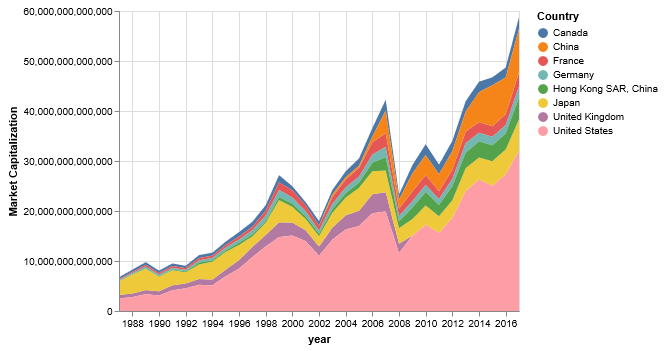

In [6]:
#2.3 Plotando gráfico
chart=alt.Chart(top_market_chart).mark_area().encode(
    x='year:T',
    y='Market Capitalization:Q',
    color='Country:N'
)
chart

In [7]:
#3 Crindo gráfico de comparação da taxa real de juros americana e pib mundial

#3.1 Criando tabela do pib mundial que seja possível juntar com taxa real de juros americana de modo que seja fácil a utilização do altair
gdp_world = cd.clean_tb(data2[0]).T['World']
gdp_world = pd.DataFrame({'Year':gdp_world.index[3:],'Gdp_World':gdp_world[3:]})
gdp_world=gdp_world[3:-1]
gdp_world

,Year,Gdp_World
1963,1963,514.702
1964,1964,552.503
1965,1965,589.749
1966,1966,626.618
1967,1967,653.255
1968,1968,690.673
1969,1969,744.871
1970,1970,802.275
1971,1971,868.062
1972,1972,981.136


In [8]:
#3.2 Criando tabela da taxa real de juros americana
real_rate = pd.DataFrame(analyze(data,"c-United States")['Real interest rate (%)'])
real_rate.reset_index(level=0, inplace=True)
real_rate.columns=['Year','Real_rate_us']
real_rate = real_rate[:-1]
real_rate.index=gdp_world.index
real_rate

,Year,Real_rate_us
1963,1963,3.37488
1964,1964,2.95167
1965,1965,2.56591
1966,1966,2.64942
1967,1967,2.40623
1968,1968,1.86391
1969,1969,2.85177
1970,1970,5.57526
1971,1971,0.614434
1972,1972,0.880974


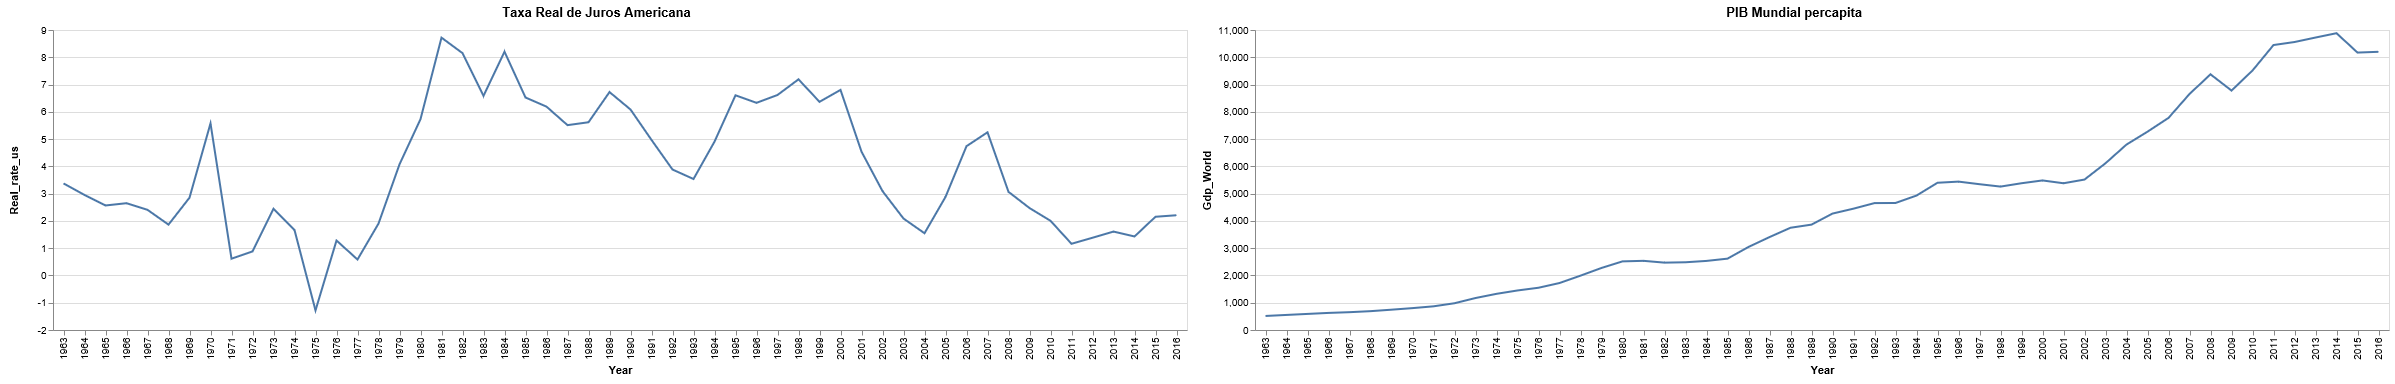

In [9]:
#3.3 Plotando Gráfico
join = pd.DataFrame(gdp_world).join(real_rate['Real_rate_us'])
alt.renderers.enable('notebook')
brush = alt.selection(type='interval', encodings=['x'])

real_rate_chart = alt.Chart(join).mark_line().encode(
  x=alt.X('Year:N'),
  y=alt.Y('Real_rate_us:Q')
).properties(
  title='Taxa Real de Juros Americana'
).add_selection(
    brush
)


gdp_world_chart = alt.Chart(join).mark_line().encode(
  x=alt.X('Year:N', scale=alt.Scale(zero=False)),
  y=alt.Y('Gdp_World:Q', scale=alt.Scale(zero=False)),
).properties(
  title='PIB Mundial percapita'
).transform_filter(
  brush
)


real_rate_chart | gdp_world_chart